# Combination Survey Results

The primary goal of notebook is to take the survey results and group them by postal codes

In [161]:
from pprint import pprint
from collections import defaultdict

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [162]:
def cross_tab_categorical_fields(input_df, flds, plz_fld='PLZ'):
    df = input_df[flds + [plz_fld]]
    df = df.melt(value_vars=flds, id_vars=plz_fld, var_name='question')
    ctab_df = pd.crosstab([df.question, df[plz_fld]], df.value)
    
    return ctab_df

In [163]:
DAILYMOB_FLDS = [f'DAILYMOB{x}' for x in range(1, 8)]

DAILYMOB_KEY = {
  0: 'n/a',
  1: 'Walking', # Zu Fuß
  2: 'Auto',
  3: 'Bicycle', # Fahrrad / E-Bike
  4: 'Bus',
  5: 'Train', # Bahn
  6: 'Motorcycle', # Motorrad
  7: 'Ferry', # Fähre
  8: 'Bike-Sharing',
  9: 'Car-Sharing'
}

VERHLT_FLDS = [
    'MOBIVERHALTEN11WegezuFuß',
    'MOBIVERHALTEN12',
    'MOBIVERHALTEN21FahrradEBike',
    'MOBIVERHALTEN22',
    'MOBIVERHALTEN31AutoalsFahrer',
    'MOBIVERHALTEN32',
    'MOBIVERHALTEN41AutoalsMitfahrer',
    'MOBIVERHALTEN42',
    'MOBIVERHALTEN51Busverkehr',
    'MOBIVERHALTEN52',
    'MOBIVERHALTEN61Bahnverkehr',
    'MOBIVERHALTEN62',
    'MOBIVERHALTEN71Motorrad',
    'MOBIVERHALTEN72',
    'MOBIVERHALTEN81Fähre',
    'MOBIVERHALTEN82',
    'MOBIVERHALTEN91BikeSharing',
    'MOBIVERHALTEN92',
    'MOBIVERHALTEN101CarSharing',
    'MOBIVERHALTEN102'
]

VERHLT_KEY = {
    0: 'n/a',
    1: 'daily or almost', # '(fast) täglich',
    2: '1-3 days per week', # 'an 1-3 Tagen pro Woche',
    3: 'seldom', # 'seltener',
    4: 'never or almost' # '(fast) nie ',
}

DAUER_ARTEN = ['PKW', 'OPNV', 'RAD', 'EBIKE', 'FUSS', 'MOTOR', 'FAHRE', 'KOMBI']
DAUER_FLDS = [f'GESCHDAUER{x}' for x in DAUER_ARTEN]

STUDY_AREA_PLZ = [
    24107,
    24109,
    24229,
    24113,
    24161,
    24111,
    24119,
    24106,
    24145,
    24114,
    24116,
    24118,
    24159,
    24103,
    24105,
    24143,
    24148,
    24147,
    24146,
    24149,
    24248,
    24226,
    24222,
    24232,
    24223,
    24235,
]

PLZ_GRPS = {
    'city_center': [
        24106,
        24118,
        24105,
        24116,
        24103,
        24114
    ],
    'west_kiel': [
        24107,
        24119,
        24109,
        24111,
        24113
    ],
    'east_kiel': [
        24145,
        24143,
        24148,
        24147,
        24146,
        24223,
        24232,
        24222,
        24149,
        24248
    ],
    'north_kiel': [
        24229,
        24161,
        24159,
        24226,
        24235
    ]
}


In [181]:
replace_mappings = {}
replace_mappings.update({
    fld: DAILYMOB_KEY for fld in DAILYMOB_FLDS
})
replace_mappings.update({
    fld: VERHLT_KEY for fld in VERHLT_FLDS
})
main_df = pd.read_csv('./data/210920_Datensatz_cleaned_V2_travis.csv', sep=';')
# pprint(replace_mappings)
main_df = main_df.replace(replace_mappings)
main_df = main_df[main_df.PLZ.isin(STUDY_AREA_PLZ)]

# add count column for later usage
main_df['count'] = 1

# The following lines add a new column "survey_areas" that is used to add a geographic category to the data.
main_df['survey_areas'] = None

for grp, plz_codes in PLZ_GRPS.items():
    main_df.loc[main_df.PLZ.isin(plz_codes), 'survey_areas'] = grp

In [182]:
df = pd.DataFrame(main_df.groupby('PLZ').count()['idStud1'])

df.to_csv('./data/plz_counts.csv')

count    303.000000
mean      40.831683
std       12.267765
min       19.000000
25%       30.500000
50%       39.000000
75%       51.000000
max       71.000000
Name: alter, dtype: float64


<AxesSubplot:>

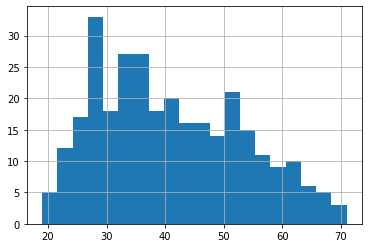

In [183]:
print(main_df['alter'].describe())
main_df['alter'].hist(bins=20)

In [184]:
main_df.groupby('geschlecht').count()['idStud1']

geschlecht
1    143
2    159
3      1
Name: idStud1, dtype: int64

In [185]:
main_df.groupby('survey_areas').count()['idStud1']

survey_areas
city_center    141
east_kiel       67
north_kiel      39
west_kiel       56
Name: idStud1, dtype: int64

<AxesSubplot:>

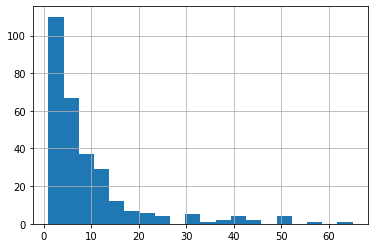

In [186]:
distance = main_df[(main_df['DISTANZ'] >= 0) & (main_df['DISTANZ'] < 80)]
distance['DISTANZ'].hist(bins=20)

In [187]:
# Get the daily mobility habits by postal code (this can be repeated for other question groups)
# DAILYMOB1-->[Arbeits-/Ausbildungs-/Schulweg]
# Bitte wählen Sie das Verkehrsmittel, mit dem Sie die folgenden Aktivitäten am häufigsten ausführen.

dailymob_df = cross_tab_categorical_fields(main_df, MOB_FLDS, plz_fld='survey_areas')

## Show mobility split per question for a region in Kiel

To change the region, update the code.

In [188]:
top_labels = ['Auto', 'Bicycle', 'Walking', 'Bus', 'Train'] # + ['Bike-Sharing', 'Car-Sharing', 'Ferry', 'Motorcycle']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)',
          'rgba(190, 192, 213, 1)']

city_region = 'west_kiel'

y_data = [f'DAILYMOB{x}' for x in range(1, 8)]
x_data_raw = [dailymob_df.loc[question, city_region][top_labels] for question in y_data]

# Convert to percentages
x_data = [round(100 * series / sum(series)) for series in x_data_raw]

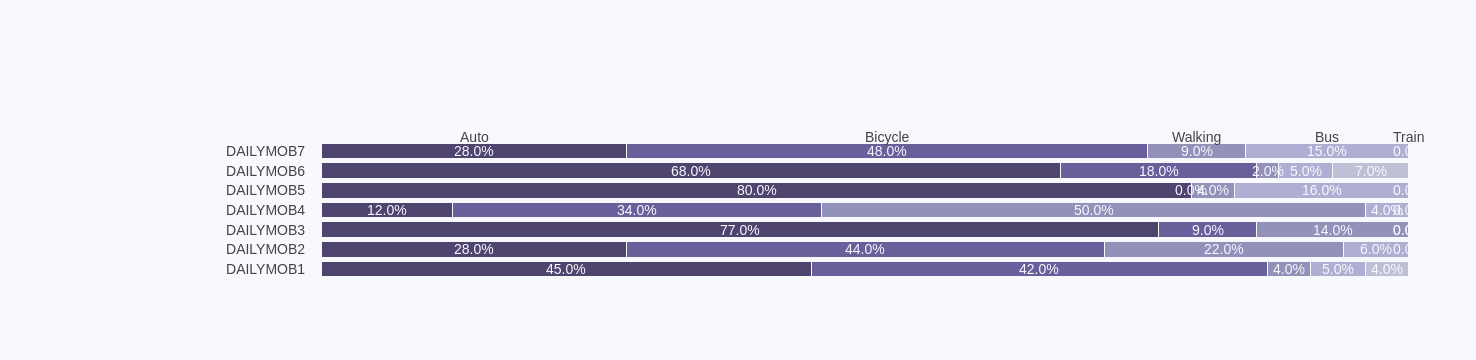

In [189]:
fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=120, r=10, t=140, b=80),
    showlegend=False,
)

annotations = []

for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(xd[0]) + '%',
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(xd[i]) + '%',
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations)

fig.show()

## Correlate walkability and survey results

In this step we create a simple chart that plots walkability average against the percent of trips made with the car.

To do this, I first sample the results sets so that we are comparing groups of the same size from each city region.
The lowest participant count came from the "North Kiel" region and was `39` and therefore also the `sample_size` paramter.

### Make a sample of survey responses to compare survey areas

In [201]:
counts = main_df.groupby('survey_areas').sum()['count']

# Lowest count of participants in a survey area
sample_amount = min(counts.filter(PLZ_GRPS.keys()))
data_subset = None

# print(sample_amount)
for key in PLZ_GRPS.keys():
    sample = main_df[main_df['survey_areas'] == key].sample(n=sample_amount, random_state=1)

    if data_subset is None:
        data_subset = sample
    else:
        data_subset = data_subset.append(sample)

### Calculate average mobility usage of car vs. no car

Here, we average the usage across the seven categories of usage. 
Although the data show nine different mobility types, this analysis is only 
concerned with "car" vs. "no car".


In [202]:
dailymob_df = cross_tab_categorical_fields(data_subset, MOB_FLDS, plz_fld='survey_areas')

auto_vs_non_auto = {}

for idx, question in enumerate(DAILYMOB_FLDS, start=1):
    for grp in PLZ_GRPS.keys():
        series = dailymob_df.loc[question, grp][top_labels]
        if auto_vs_non_auto.get(grp) is None:
            auto_vs_non_auto[grp] = {
                'auto': [],
                'non_auto': []
            }

        auto_vs_non_auto[grp]['auto'].append(
            round(100 * series['Auto'] / sum(series))
        )
        auto_vs_non_auto[grp]['percent_auto'] = round(sum(auto_vs_non_auto[grp]['auto']) / idx)
        
        non_auto_records = series[[x for x in top_labels if x != 'Auto']]
        auto_vs_non_auto[grp]['non_auto'].append(
            round(100 * sum(non_auto_records) / sum(series))
        )
        auto_vs_non_auto[grp]['percent_non_auto'] = round(sum(auto_vs_non_auto[grp]['non_auto']) / idx)


### Create simple scatter plot graph to see correlation

It appears that the variables "walkability" and "percent auto users" is positively correlated, which means that areas of lower car use enjoy better walkability.

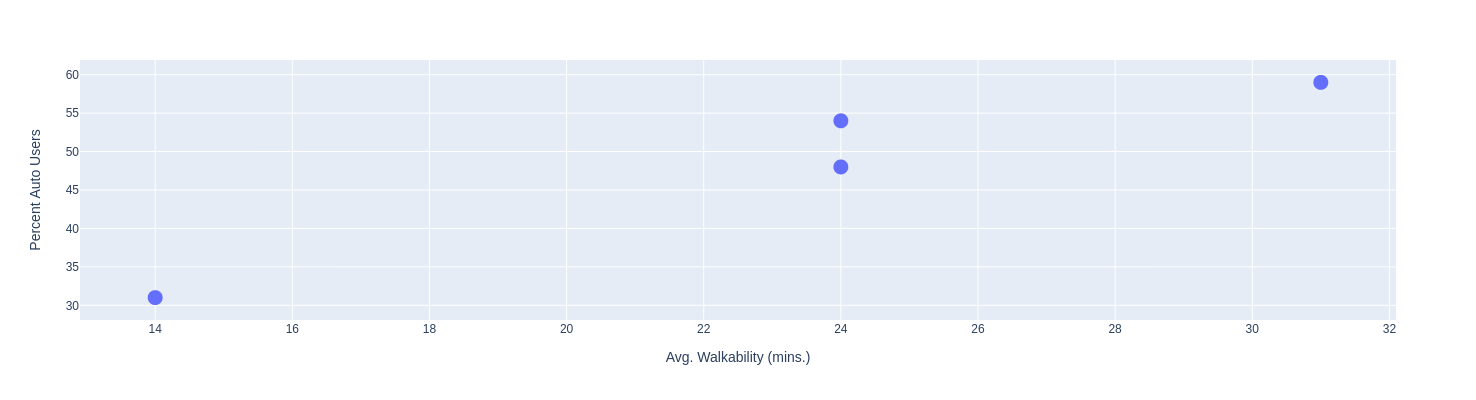

In [203]:
# These numbers manually entered from QGIS
walk_mean = {
    'east_kiel': 1455.126, 
    'west_kiel': 1447.483, 
    'north_kiel': 1876.144,
    'city_center': 830.171
}

x_data = []
y_data = []

for key, dailymob_data in auto_vs_non_auto.items():
    x_data.append(walk_mean[key])
    y_data.append(dailymob_data['percent_auto'])

x_data = [round(x / 60) for x in x_data]

fig = px.scatter(
    x=x_data, y=y_data,
    width=600, height=400,
    labels={
        'x': 'Avg. Walkability (mins.)',
        'y': 'Percent Auto Users'
    })
fig.update_traces(marker_size=15)
fig.show()

In [39]:
# This is for the distances. Using the mean function as an aggregate would work well here.
dauer_cols = DAUER_FLDS + ['PLZ']
dauer_df = data[dauer_cols]

dauer_df = dauer_df.melt(value_vars=DAUER_FLDS, id_vars='PLZ', var_name='question')
dauer_df = dauer_df[dauer_df['value'] >= 0]
dauer_df.pivot_table(index=['PLZ', 'question'], values='value')  # defaults to using 'mean' as aggfunc

value
PLZ   question                  
24103 GESCHDAUEREBIKE  17.636364
      GESCHDAUERFAHRE  30.000000
      GESCHDAUERFUSS   57.800000
      GESCHDAUERKOMBI  25.000000
      GESCHDAUERMOTOR  16.625000
...                          ...
24248 GESCHDAUERKOMBI  20.000000
      GESCHDAUERMOTOR  11.000000
      GESCHDAUEROPNV   25.000000
      GESCHDAUERPKW    11.000000
      GESCHDAUERRAD    20.000000

[199 rows x 1 columns]

In [37]:
# MOBIVERHALTEN11WegezuFuß-->[Wege zu Fuß] [Skala 1] 
# Bitte geben Sie für die folgenden Verkehrsmittel an, wie oft Sie diese in Ihrem normalen Alltag verwenden.
cross_tab_categorical_fields(data, VRHLT_FLDS)

value                             1-3 days per week  daily or almost  n/a  \
question                   PLZ                                              
MOBIVERHALTEN101CarSharing 24103                  1                0    1   
                           24105                  0                0    4   
                           24106                  0                0    3   
                           24107                  0                0    2   
                           24109                  0                0    2   
...                                             ...              ...  ...   
MOBIVERHALTEN92            24226                  0                0    0   
                           24229                  0                0    0   
                           24232                  0                0    2   
                           24235                  0                0    2   
                           24248                  0                0    0   

value                             never or almost  seldom  
question                   PLZ                             
MOBIVERHALTEN101CarSharing 24103               14       0  
                           24105               19       3  
                           24106               23       3  
                           24107               13       0  
                           24109                5       0  
...                                           ...     ...  
MOBIVERHALTEN92            24226                8       0  
                           24229                5       0  
                           24232                2       0  
                           24235                2       0  
                           24248                1       1  

[520 rows x 5 columns]

In [22]:
for col in data.columns:
    print(col)

email
idStud1
KIELYN
UMLAND
PLZ
ARBEITSORT
DISTANZ
GESCHDAUERPKW
GESCHDAUEROPNV
GESCHDAUERRAD
GESCHDAUEREBIKE
GESCHDAUERFUSS
GESCHDAUERMOTOR
GESCHDAUERFAHRE
GESCHDAUERKOMBI
Q1
Q1NO
Q1YESQ2
Q1YESQ3
Q1YESQ4
Q1YESQ5
bicycleQ7
bicycleQ8
bicycleQ9
bicycleQ10
bicycleQ11
walkingQ12
walkingQ13
walkingQ14
publicQ15
publicQ16
climateQ17
climateQ18
SEGMENT_EN
SEGMENT_DE
DAILYMOB1
DAILYMOB2
DAILYMOB3
DAILYMOB4
DAILYMOB5
DAILYMOB6
DAILYMOB7
REASONCAR1
REASONCAR2
REASONCAR3
REASONCAR4
REASONCAR5
REASONCAR6
REASONCAR7
REASONCAR8
REASONCARother
MOBIVERHALTEN11WegezuFuß
MOBIVERHALTEN12
MOBIVERHALTEN21FahrradEBike
MOBIVERHALTEN22
MOBIVERHALTEN31AutoalsFahrer
MOBIVERHALTEN32
MOBIVERHALTEN41AutoalsMitfahrer
MOBIVERHALTEN42
MOBIVERHALTEN51Busverkehr
MOBIVERHALTEN52
MOBIVERHALTEN61Bahnverkehr
MOBIVERHALTEN62
MOBIVERHALTEN71Motorrad
MOBIVERHALTEN72
MOBIVERHALTEN81Fähre
MOBIVERHALTEN82
MOBIVERHALTEN91BikeSharing
MOBIVERHALTEN92
MOBIVERHALTEN101CarSharing
MOBIVERHALTEN102
covidchange
coviddiff1
coviddiff2
covi